In [73]:
import pandas as pd
import numpy as np
import os

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.font_manager as fm
import matplotlib.ticker as mticker

from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

from datetime import datetime

In [74]:
class PlotData:
   
    def __init__(self):
        
        self.export_img = "../../report/img"
        self.processed_folder = "../../data/processed"

        os.makedirs(self.export_img, exist_ok=True)

    def plot_fiveyr_seasonal(self, file_import_name, chart_title, size, legend=None):

        # Import Data

        file_path_import = os.path.join(self.processed_folder, file_import_name)
        df = pd.read_csv(file_path_import)

        # Cleaning the Data

        # Rename the columns for easier access
        df.columns = ['Date', 'Data']

        # Convert 'Date' column to datetime format
        df['Date'] = pd.to_datetime(df['Date'])

        # Extract week number, month, and year
        df['Week_Num'] = df['Date'].dt.isocalendar().week
        df['Month'] = df['Date'].dt.month
        df['Year'] = df['Date'].dt.year

        # Pivot the Data

        # Pivot the DataFrame to have Week_Num as rows, Year as columns, and Data as values
        pivoted_df = df.pivot_table(index='Week_Num', columns='Year', values='Data')
        
        # Sort the columns to have years starting from the newest
        pivoted_df = pivoted_df.sort_index(axis=1, ascending=False)

        pivoted_df = pivoted_df.iloc[:,:6]
        
        # Remove NaN values from last row
        pivoted_df.iloc[:,1:] = pivoted_df.iloc[:,1:].ffill()

        fiveYearsRange = pivoted_df

        # Calculate the 5-year max, min, and average for each row
        pivoted_df["5YrMax"] = fiveYearsRange.max(axis=1)
        pivoted_df["5YrMin"] = fiveYearsRange.min(axis=1)
        pivoted_df["5YrAvg"] = fiveYearsRange.mean(axis=1)
        
        

        # Plot the Data

        # Paths to your Montserrat font files
        font_path = '../assets/Montserrat/static/Montserrat-Regular.ttf'
        font_path_bold = '../assets/Montserrat/static/Montserrat-Black.ttf'
        
        # Register the font properties
        prop = fm.FontProperties(fname=font_path)
        prop_black = fm.FontProperties(fname=font_path_bold)

        pivot_dataset = pivoted_df

        # Ensure plot_data is sorted by index (Week)
        plot_data = pivot_dataset.sort_index()

        # Create a numerical range for the x-axis based on the length of the DataFrame
        x_values = np.arange(len(plot_data)) + 1

        # Size Chart
        plt.figure(figsize=(size[0], size[1]))  # Adjusted height for better visibility

        # Plot the 5-Year Max/Min range as a shaded area
        plt.fill_between(x_values, plot_data['5YrMax'], plot_data['5YrMin'], color='lightgray', label='5-Year Range')

        # Colors
        fiveYear_avgColor = "black"
        fiveYear_PrevYrColor = "#FFA500"
        fiveYear_CurrentYrColor = "#003366"

        # Years

        current_yr = datetime.now().year
        previous_yr = current_yr - 1

        # Plot 5-Year Average and actual values
        plt.plot(plot_data.index, plot_data['5YrAvg'], color=fiveYear_avgColor, linestyle='--', label='5-Year Average', linewidth=1)
        plt.plot(plot_data.index, plot_data[previous_yr], color=fiveYear_PrevYrColor, label=f'{previous_yr}', linewidth=1.5, alpha=0.7)
        plt.plot(plot_data.index, plot_data[current_yr], color=fiveYear_CurrentYrColor, marker='o', label=f'{current_yr}', linewidth=2)

         # Format y-axis values
        def thousands(x, pos):
            """Format the y-axis values with a dot as the thousand separator."""
            return f'{x/1000:,.0f}'.replace(',', '.')
        plt.gca().yaxis.set_major_formatter(mticker.FuncFormatter(thousands))
        
        y_label = "Million Barrels"

        if legend == None:
        
            plt.title(f'{chart_title}', fontproperties=prop_black, size=14, pad=10)  # Larger title with size specified in title
            plt.xlabel("Week", fontproperties=prop, size=10)  # Larger x-label
            plt.ylabel(y_label, fontproperties=prop, size=10)  # Larger y-label

            # Place legend with regular font
            plt.legend(loc='upper right', prop=prop)
        
        else:

            plt.title(f'{chart_title}', fontproperties=prop_black, size=12, pad=10)  # Larger title with size specified in title
            plt.xlabel("Week", fontproperties=prop, size=12)  # Larger x-label
            plt.ylabel(y_label, fontproperties=prop, size=12)  # Larger y-label

        plt.grid(True, linestyle='--', alpha=0.6)  # Add consistent grid style
        plt.tight_layout()

        # Save the plot as a PNG file
        export_file_name = f'{chart_title}'.replace(" ", "").replace("-", "") + ".png"
        export_file_path = os.path.join(self.export_img, export_file_name)

        os.makedirs(self.export_img, exist_ok=True)
        plt.savefig(export_file_path, bbox_inches='tight')

        # Show the plot
        plt.show()

        return pivoted_df
    
    def poly_calc(self, file_import_name, chart_title, size):
        
        # Import Data

        file_path_import = os.path.join(self.processed_folder, file_import_name)
        df = pd.read_csv(file_path_import)

        # Cleaning the Data

        # Rename the columns for easier access
        df.columns = ['Date', 'Data']

        # Convert 'Date' column to datetime format
        df['Date'] = pd.to_datetime(df['Date'])

        # Extract week number, month, and year
        df['Week_Num'] = df['Date'].dt.isocalendar().week
        df['Month'] = df['Date'].dt.month
        df['Year'] = df['Date'].dt.year

        # Pivot the Data

        # Pivot the DataFrame to have Week_Num as rows, Year as columns, and Data as values
        pivoted_df = df.pivot_table(index='Week_Num', columns='Year', values='Data')
        
        # Sort the columns to have years starting from the newest
        pivoted_df = pivoted_df.sort_index(axis=1, ascending=False)

        pivoted_df = pivoted_df.iloc[:,:6]

        data = pivoted_df

        # Ensure the length of x_date and y_num are the same
        x_date = data.index.values.reshape(-1, 1)

        current_year = datetime.now().year
        prev_year = current_year - 1
        prev_prev_year = current_year - 2

        # Current year
        y_num = pivoted_df[current_year].values

        # Filter out NaN values for fitting
        valid_idx = ~np.isnan(y_num)  # Boolean index for non-NaN values
        x_date_valid = x_date[valid_idx]
        y_num_valid = y_num[valid_idx]

        # Create polynomial features
        poly = PolynomialFeatures(degree=3)
        x_poly = poly.fit_transform(x_date)

        # Fit the linear regression model using valid (non-NaN) data
        model = LinearRegression()
        model.fit(x_poly[valid_idx], y_num_valid)  # Fit only on valid data points

        # Make predictions using the model
        y_pred_curryr = model.predict(x_poly)

        # Mask predictions for NaN values
        y_pred_curryr_with_na = np.where(np.isnan(y_num), np.nan, y_pred_curryr)
        
        # Previous Year

        # Fill missing values in y_num with NaN for visualization purposes
        y_num = data[prev_year].values
        y_num_filled = y_num.copy()
        y_num_filled[np.isnan(y_num)] = np.nan  # Explicitly set NaN for missing values

        # Create polynomial features
        poly = PolynomialFeatures(degree=3)
        x_poly = poly.fit_transform(x_date)

        # Fit the linear regression model (use filled values)
        model = LinearRegression()
        model.fit(x_poly[~np.isnan(y_num)], y_num[~np.isnan(y_num)])  # Fit only on valid data points

        # Make predictions
        y_pred_prevyr = model.predict(x_poly)

        # Previous Previous Year

        # Fill missing values in y_num with NaN for visualization purposes
        y_num = data[prev_prev_year].values
        y_num_filled = y_num.copy()
        y_num_filled[np.isnan(y_num)] = np.nan  # Explicitly set NaN for missing values

        # Create polynomial features
        poly = PolynomialFeatures(degree=3)
        x_poly = poly.fit_transform(x_date)

        # Fit the linear regression model (use filled values)
        model = LinearRegression()
        model.fit(x_poly[~np.isnan(y_num)], y_num[~np.isnan(y_num)])  # Fit only on valid data points

        # Make predictions
        y_pred_prevprevyr = model.predict(x_poly)
        
        poly_dataset = pd.DataFrame([y_pred_curryr_with_na, y_pred_prevyr, y_pred_prevprevyr], index=[f'poly_{current_year}', f'poly_{prev_year}', f'poly_{prev_prev_year}']).T
        poly_dataset.index = range(1, len(poly_dataset) + 1)

        print(poly_dataset)
        
        # Ploting Chart

        fiveYearsRange = pivoted_df

        # Calculate the 5-year max, min, and average for each row
        pivoted_df["5YrMax"] = fiveYearsRange.max(axis=1)
        pivoted_df["5YrMin"] = fiveYearsRange.min(axis=1)
        pivoted_df["5YrAvg"] = fiveYearsRange.mean(axis=1)

        # Plot the Data

        # Paths to your Montserrat font files
        font_path = '../assets/Montserrat/static/Montserrat-Regular.ttf'
        font_path_bold = '../assets/Montserrat/static/Montserrat-Black.ttf'
        
        # Register the font properties
        prop = fm.FontProperties(fname=font_path)
        prop_black = fm.FontProperties(fname=font_path_bold)

        pivot_dataset = pivoted_df

        # Ensure plot_data is sorted by index (Week)
        plot_data = pivot_dataset.sort_index()

        # Create a numerical range for the x-axis based on the length of the DataFrame
        x_values = np.arange(len(plot_data)) + 1

        # Size Chart
        plt.figure(figsize=(size[0], size[1]))  # Adjusted height for better visibility

        # Plot the 5-Year Max/Min range as a shaded area
        plt.fill_between(x_values, plot_data['5YrMax'], plot_data['5YrMin'], color='lightgray', label='5-Year Range')

        # Colors
        PrevPrevYrColor = "#7F588E"
        PrevYrColor = "#FFA500"
        CurrentYrColor = "#003366"

        # Years

        # Plot 5-Year Average and actual values
        plt.plot(poly_dataset.index, poly_dataset[f"poly_{prev_prev_year}"], color=PrevPrevYrColor, label=f'Poly. {prev_prev_year}', linewidth=1.5, alpha=0.7)
        plt.plot(poly_dataset.index, poly_dataset[f"poly_{prev_year}"], color=PrevYrColor, label=f'Poly. {prev_year}', linewidth=1.5, alpha=0.7)
        plt.plot(poly_dataset.index, poly_dataset[f"poly_{current_year}"], color=CurrentYrColor, label=f'Poly. {current_year}', linewidth=1.5, alpha=0.7)

                 # Format y-axis values
        def thousands(x, pos):
            """Format the y-axis values with a dot as the thousand separator."""
            return f'{x/1000:,.2f}'.replace(',', '.')
        plt.gca().yaxis.set_major_formatter(mticker.FuncFormatter(thousands))
        
        y_label = "Million Barrels"

        plt.title(f'{chart_title}', fontproperties=prop_black, size=20, pad=10)  # Larger title with size specified in title
        plt.xlabel("Week", fontproperties=prop, size=14)  # Larger x-label
        plt.ylabel(y_label, fontproperties=prop, size=14)  # Larger y-label

        # Place legend with regular font
        plt.legend(loc='lower right', prop=prop)

        plt.grid(True, linestyle='--', alpha=0.6)  # Add consistent grid style
        plt.tight_layout()

        # Save the plot as a PNG file
        export_file_name = f'{chart_title}'.replace(" ", "").replace("-", "") + ".png"
        export_file_path = os.path.join(self.export_img, export_file_name)

        os.makedirs(self.export_img, exist_ok=True)
        plt.savefig(export_file_path, bbox_inches='tight')

        # Show the plot
        plt.show()

        return poly_dataset
    
    def z_score_calc(self, file_import_name, chart_title, size):
        
        # Import Data

        file_path_import = os.path.join(self.processed_folder, file_import_name)
        df = pd.read_csv(file_path_import)

        # Cleaning the Data

        # Rename the columns for easier access
        df.columns = ['Date', 'Data']

        # Convert 'Date' column to datetime format
        df['Date'] = pd.to_datetime(df['Date'])

        # Extract week number, month, and year
        df['Week_Num'] = df['Date'].dt.isocalendar().week
        df['Month'] = df['Date'].dt.month
        df['Year'] = df['Date'].dt.year

        # Pivot the Data

        # Pivot the DataFrame to have Week_Num as rows, Year as columns, and Data as values
        pivoted_df = df.pivot_table(index='Week_Num', columns='Year', values='Data')
        
        # Sort the columns to have years starting from the newest
        pivoted_df = pivoted_df.sort_index(axis=1, ascending=False)

        pivoted_df = pivoted_df.iloc[:,:13]
        
        # Calculating the Z-Score
        
        z_score_columns = []
    
        rowIndex = 1
        i = 0
        
        while rowIndex < 7:
            # Current Year
            z_score_dataset = pivoted_df.iloc[:,rowIndex:(12+i)]
            tenYearsRange = pivoted_df.iloc[:, rowIndex:(12+i)]
            
            # # Calculate the 10-year mean and std for each row
            z_score_dataset["TimeAverage"] = tenYearsRange.mean(axis=1)
            z_score_dataset["TimeStd"] = tenYearsRange.std(axis=1)
            
            # Calculate the 10-year mean and std for each row (e.g., each month)
            z_score_dataset["TimeAverage"] = tenYearsRange.mean(axis=1)
            z_score_dataset["TimeStd"] = tenYearsRange.std(axis=1)
            
            # Calculate the Z-score for the current year (assuming it's the first column)
            current_year_column = z_score_dataset.columns[0]  # First column of the dataset
            z_score_year = (
                (z_score_dataset[current_year_column] - z_score_dataset["TimeAverage"]) 
                / z_score_dataset["TimeStd"]
            )
            
            z_score_columns.append(z_score_year)
            
            rowIndex += 1
            i += 1
        
            # Create a DataFrame
        zScore_dataset = pd.DataFrame({
            f'{pivoted_df.columns[0]}': z_score_columns[0],
            f'{pivoted_df.columns[1]}': z_score_columns[1],
            f'{pivoted_df.columns[2]}': z_score_columns[2],
            f'{pivoted_df.columns[3]}': z_score_columns[3],
            f'{pivoted_df.columns[4]}': z_score_columns[4],
            f'{pivoted_df.columns[5]}': z_score_columns[5],
        })
        
         
        zScore_dataset.iloc[pivoted_df.isna().any(axis=1).to_numpy().argmax():,0] = float('nan')
        
        # Plotting Chart
        
        # Paths to your Montserrat font files
        font_path = '../assets/Montserrat/static/Montserrat-Regular.ttf'
        font_path_bold = '../assets/Montserrat/static/Montserrat-Black.ttf'
        
        # Register the font properties
        prop = fm.FontProperties(fname=font_path)
        prop_bold = fm.FontProperties(fname=font_path_bold)

        # Prepare data
        plot_data = zScore_dataset.copy()
        
        # Ensure plot_data is sorted by index (Week)
        plot_data = plot_data.sort_index()
        
        
        # Identify current year, previous year, and previous previous year (assumes columns are sorted in descending order)
        current_year = datetime.now().year
        prev_year = current_year - 1
        prev_prev_year = current_year - 2
        
        # Size Chart
        plt.figure(figsize=(size[0], size[1]))  # Adjusted height for better visibility

        # Colors
        PrevPrevYrColor = "#7F588E"
        PrevYrColor = "#FFA500"
        CurrentYrColor = "#003366"
        
        plt.plot(plot_data.index, plot_data[f"{prev_prev_year}"], color=PrevPrevYrColor, label=f'ZScore{prev_prev_year}', linewidth=1.5, alpha=0.7)
        plt.plot(plot_data.index, plot_data[f"{prev_year}"], color=PrevYrColor, label=f'ZScore{prev_year}', linewidth=1.5, alpha=0.7)
        plt.plot(plot_data.index, plot_data[f"{current_year}"], color=CurrentYrColor, label=f'ZScore{current_year}', linewidth=1.5, alpha=0.7)

        # Customize the plot with Montserrat font
        plt.title(f"{chart_title}", fontproperties=prop_bold, size=20, pad=10)
        plt.xlabel("Week", fontsize=14, fontproperties=prop)
        plt.ylabel("Std Away from 10-yr Avg.", fontsize=14, fontproperties=prop)

        # Position the legend in the top-left corner with a highlighted background
        # Place legend with regular font
        plt.legend(loc='upper right', prop=prop)
        plt.grid(True, linestyle='--', alpha=0.6)  # Add consistent grid style
        plt.tight_layout()

        # Add grid
        plt.grid(True)

        # Adjust layout
        plt.tight_layout()

        # Save the plot as a PNG file
        export_file_name = f'{chart_title}'.replace(" ", "").replace("-", "") + ".png"
        export_file_path = os.path.join(self.export_img, export_file_name)

        os.makedirs(self.export_img, exist_ok=True)
        plt.savefig(export_file_path, bbox_inches='tight')
        
        plt.show()  # Displays the plot
        
    def implied_fourweek_demand(self, file_import_name, chart_title, size, legend=None):
        
        # Import Data

        file_path_import = os.path.join(self.processed_folder, file_import_name)
        df = pd.read_csv(file_path_import)

        # Cleaning the Data

        # Rename the columns for easier access
        df.columns = ['Date', 'Data']

        # Convert 'Date' column to datetime format
        df['Date'] = pd.to_datetime(df['Date'])

        # Extract week number, month, and year
        df['Week_Num'] = df['Date'].dt.isocalendar().week
        df['Month'] = df['Date'].dt.month
        df['Year'] = df['Date'].dt.year
        
        # Sort by Date (if not already sorted)
        df = df.sort_values("Date")

        # Calculate the 4-week rolling average
        df_four_week_avg = df["Data"].rolling(window=4).mean()
        df["Data"] = df_four_week_avg
        
        # Pivot the DataFrame to have Week_Num as rows, Year as columns, and Data as values
        pivoted_df = df.pivot_table(index='Week_Num', columns='Year', values='Data')
        
        # Sort the columns to have years starting from the newest
        pivoted_df = pivoted_df.sort_index(axis=1, ascending=False)

        pivoted_df = pivoted_df.iloc[:,:6]

        fiveYearsRange = pivoted_df

        # Calculate the 5-year max, min, and average for each row
        pivoted_df["5YrMax"] = fiveYearsRange.max(axis=1)
        pivoted_df["5YrMin"] = fiveYearsRange.min(axis=1)
        pivoted_df["5YrAvg"] = fiveYearsRange.mean(axis=1)

        # Plot the Data

        # Paths to your Montserrat font files
        font_path = '../assets/Montserrat/static/Montserrat-Regular.ttf'
        font_path_bold = '../assets/Montserrat/static/Montserrat-Black.ttf'
        
        # Register the font properties
        prop = fm.FontProperties(fname=font_path)
        prop_black = fm.FontProperties(fname=font_path_bold)

        pivot_dataset = pivoted_df

        # Ensure plot_data is sorted by index (Week)
        plot_data = pivot_dataset.sort_index()

        # Create a numerical range for the x-axis based on the length of the DataFrame
        x_values = np.arange(len(plot_data)) + 1

        # Size Chart
        plt.figure(figsize=(size[0], size[1]))  # Adjusted height for better visibility

        # Plot the 5-Year Max/Min range as a shaded area
        plt.fill_between(x_values, plot_data['5YrMax'], plot_data['5YrMin'], color='lightgray', label='5-Year Range')

        # Colors
        fiveYear_avgColor = "black"
        fiveYear_PrevYrColor = "#FFA500"
        fiveYear_CurrentYrColor = "#003366"

        # Years

        current_yr = datetime.now().year
        previous_yr = current_yr - 1

        # Plot 5-Year Average and actual values
        plt.plot(plot_data.index, plot_data['5YrAvg'], color=fiveYear_avgColor, linestyle='--', label='5-Year Average', linewidth=1)
        plt.plot(plot_data.index, plot_data[previous_yr], color=fiveYear_PrevYrColor, label=f'{previous_yr}', linewidth=1.5, alpha=0.7)
        plt.plot(plot_data.index, plot_data[current_yr], color=fiveYear_CurrentYrColor, marker='o', label=f'{current_yr}', linewidth=2)

         # Format y-axis values
        def thousands(x, pos):
            """Format the y-axis values with a dot as the thousand separator."""
            return f'{x/1000:,.0f}'.replace(',', '.')
        plt.gca().yaxis.set_major_formatter(mticker.FuncFormatter(thousands))
        
        y_label = "Thousand Barrels"

        if legend == None:
        
            plt.title(f'{chart_title}', fontproperties=prop_black, size=20, pad=10)  # Larger title with size specified in title
            plt.xlabel("Week", fontproperties=prop, size=14)  # Larger x-label
            plt.ylabel(y_label, fontproperties=prop, size=14)  # Larger y-label

            # Place legend with regular font
            plt.legend(loc='lower right', prop=prop)
        
        else:

            plt.title(f'{chart_title}', fontproperties=prop_black, size=12, pad=10)  # Larger title with size specified in title
            plt.xlabel("Week", fontproperties=prop, size=12)  # Larger x-label
            plt.ylabel(y_label, fontproperties=prop, size=12)  # Larger y-label

        plt.grid(True, linestyle='--', alpha=0.6)  # Add consistent grid style
        plt.tight_layout()

        # Save the plot as a PNG file
        export_file_name = f'{chart_title}'.replace(" ", "").replace("-", "") + ".png"
        export_file_path = os.path.join(self.export_img, export_file_name)

        os.makedirs(self.export_img, exist_ok=True)
        plt.savefig(export_file_path, bbox_inches='tight')

        # Show the plot
        plt.show()

        return pivoted_df

    


In [75]:
class PlotTable:
   
    def __init__(self):
        
        self.processed_folder = "../../data/processed"

        os.makedirs(self.export_img, exist_ok=True)
    
    def compute_summary_table(self, file_import_name):
        file_path_import = os.path.join(self.processed_folder, file_import_name)
        df = pd.read_csv(file_path_import)

        # Ensure Date column is a datetime
        summary_table["Date"] = pd.to_datetime(summary_table["Date"])
        summary_table = summary_table.sort_values(by="Date").reset_index(drop=True)


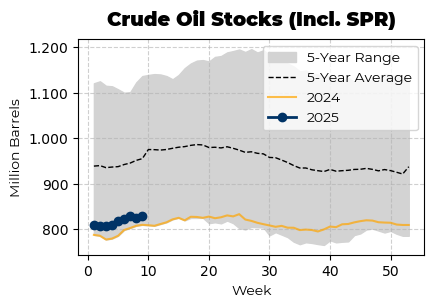

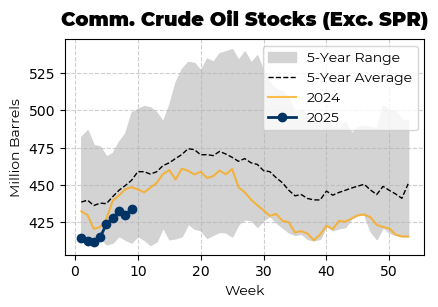

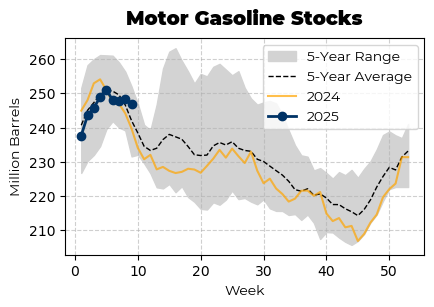

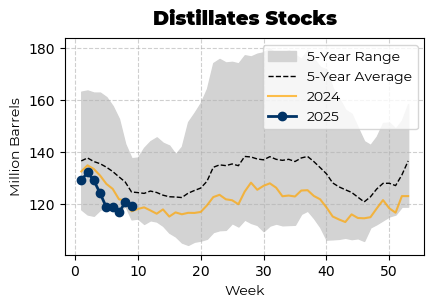

Year,2025,2024,2023,2022,2021,2020,5YrMax,5YrMin,5YrAvg
Week_Num,,,,,,,,,
1,128938.0,132383.0,117716.0,129383.0,163205.0,139050.0,163205.0,117716.0,136449.500000
2,132015.0,134753.0,115777.0,127952.0,163662.0,147221.0,163662.0,115777.0,137602.375000
3,128945.0,133336.0,115270.0,125154.0,162847.0,146036.0,162847.0,115270.0,136213.125000
4,123951.0,130795.0,117590.0,122744.0,162838.0,144747.0,162838.0,117590.0,135386.625000
5,118480.0,127574.0,120522.0,121814.0,161106.0,143235.0,161106.0,118480.0,134039.625000
6,118615.0,125659.0,119237.0,120262.0,157684.0,141222.0,157684.0,118615.0,132372.250000
7,116564.0,121651.0,121935.0,119678.0,152715.0,140587.0,152715.0,116564.0,130301.125000
8,120472.0,121141.0,122114.0,119104.0,142996.0,138472.0,142996.0,119104.0,128299.875000
9,119154.0,117010.0,122252.0,113874.0,137492.0,134464.0,137492.0,113874.0,124451.500000


In [76]:
# Export Plot 5-Yr Images
PlotData().plot_fiveyr_seasonal("us_endingcrudeoil_stocks.csv", "Crude Oil Stocks (Incl. SPR)", size = [4.445, 3.175])
PlotData().plot_fiveyr_seasonal("us_endingcommercialcrudeoil_stocks.csv", "Comm. Crude Oil Stocks (Exc. SPR)", size = [4.445, 3.175])
PlotData().plot_fiveyr_seasonal("us_endinggasoline_stocks.csv", "Motor Gasoline Stocks", size = [4.445, 3.175])
PlotData().plot_fiveyr_seasonal("us_endingdistillates_stocks.csv", "Distillates Stocks", size = [4.445, 3.175])
